<a href="https://colab.research.google.com/github/drmahmoudatef/SWT-CNN-Model/blob/main/Stationary_Wavelet_%2B_CNN_(CASIA_CMFD_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Install PyWavelets library for wavelet transforms
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
!pip install PyWavelets
!pip install pillow  # Install Pillow library for image processing


In [ ]:
# Import essential libraries
import numpy as np
import tensorflow as tf
import pywt  # Library for wavelet transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize


In [ ]:
# Import IPython utilities for interactive display
from IPython import get_ipython
from IPython.display import display


In [ ]:
# Apply SWT to a single image
def wavelet_transform(image):
    """
    Apply SWT to a single image.
    """
    # Convert image to grayscale if it is colored (ensure it's not 3D)
    if image.shape[-1] == 3:  # If the image is colored
        image = tf.image.rgb_to_grayscale(image).numpy().squeeze()

    # Ensure the image is a 2D array after grayscale conversion
    if image.ndim == 3:
        image = np.squeeze(image)  # Remove the third dimension if it exists

    # Apply SWT using PyWavelets library
    coeffs = pywt.swt2(image, 'haar', level=1)  # 'haar' is the wavelet type
    LL, (LH, HL, HH) = coeffs[0]  # Take only the first level

    # Combine the coefficients into a single image with 4 channels (LL, LH, HL, HH)
    return np.stack([LL, LH, HL, HH], axis=-1)


In [ ]:
from PIL import Image
import numpy as np
from skimage.transform import resize
import os
from tensorflow.keras.utils import Sequence

class WaveletDataGenerator(Sequence):
    def __init__(self, directory, target_size=(224, 224), batch_size=32, class_mode='binary'):
        self.directory = directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode
        self.classes = sorted(os.listdir(directory))
        # List all image files with their corresponding class
        self.files = [
            (os.path.join(directory, cls, fname), cls)
            for cls in self.classes
            for fname in os.listdir(os.path.join(directory, cls))
            if fname.endswith('.jpg') or fname.endswith('.tif')  # Ensure the files are in JPG or TIFF format
        ]
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        # Number of batches per epoch
        return len(self.files) // self.batch_size

    def __getitem__(self, idx):
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, labels = [], []
        for file, cls in batch_files:
            # Read the image using Pillow (instead of tifffile)
            img = Image.open(file)
            img = np.array(img)  # Convert image to NumPy array
            img = resize(img, self.target_size)  # Resize the image
            img_wavelet = wavelet_transform(img)  # Apply wavelet transform
            images.append(img_wavelet)
            labels.append(self.class_indices[cls])
        return np.array(images), np.array(labels)


In [ ]:
# For CASIA-CMFD Dataset

# Load data using the generator
train_generator = WaveletDataGenerator(
    '/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/train',
    target_size=(224, 224),
    batch_size=32
)

validation_generator = WaveletDataGenerator(
    '/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/val',
    target_size=(224, 224),
    batch_size=32
)

test_generator = WaveletDataGenerator(
    '/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test',
    target_size=(224, 224),
    batch_size=32
)


In [ ]:
from tensorflow.keras.layers import Input  # Importing the Input layer

model = Sequential([
    # Input layer
    Input(shape=(224, 224, 4)),  # 4 channels (LL, LH, HL, HH)

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Feature extraction
    GlobalAveragePooling2D(),

    # Dense layers
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Binary classification
])


In [ ]:
# Prepare the model for training

from tensorflow.keras.optimizers import Adam  # Import the Adam optimizer

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']         # Evaluate accuracy during training
)

# Display the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      1184      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=30,         # Random rotation up to 30 degrees
    width_shift_range=0.2,     # Random horizontal shift
    height_shift_range=0.2,    # Random vertical shift
    shear_range=0.2,           # Shear transformation
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flip
    fill_mode='nearest'        # Fill empty pixels after transformation
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Extract classes from the data generator
y_train = []
for i in range(len(train_generator)):
    _, labels = train_generator[i]
    y_train.extend(labels)
y_train = np.array(y_train)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Set up Callbacks
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.keras"

# Save the model with the best validation loss
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Log training history to CSV
log_csv = CSVLogger('VGG16_logs.csv', separator=',', append=False)

# List of callbacks to pass during training
callbacks_list = [checkpoint, log_csv]


In [ ]:
# Train the model
# Re-compile the model before fitting (if not compiled already)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Fit the model and store training history
history = model.fit(
    train_generator,               # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=15,                     # Number of training epochs
    callbacks=callbacks_list,      # Callbacks for saving best model and logging
    class_weight=class_weights_dict  # Handle class imbalance
)


In [ ]:
# Retrieve training history
history_dict = history.history

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Add main title
plt.suptitle('CASIA-CMFD Dataset', fontsize=16, fontweight='bold')

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()


In [ ]:
# save weight for CASIA-CMFD Dataset
#model.save_weights('/content/gdrive/My Drive/weights-improvement-CAS-CMDF-21-12-24.weights.h5')
#model.save_weights('/content/gdrive/My Drive/weights-improvement-CAS-CMDF-30-12-24.weights.h5')


In [ ]:
# load weight for CASIA-CMFD Dataset
model.load_weights('/content/gdrive/My Drive/weights-improvement-CAS-CMDF-21-12-24.weights.h5')
#model.load_weights('/content/gdrive/My Drive/weights-improvement-CAS-CMDF-30-12-24.weights.h5')

In [ ]:
#### For CASIA-CMFD dataset

import itertools
import matplotlib.pyplot as plt  # Importing the necessary library

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix For',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Add text annotations in each cell
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')


1/1 [==============================] - 0s 165ms/step
True Negatives: 245
False Negatives: 0
1/1 [==============================] - 0s 264ms/step


True Positives: 328
False Positives: 0
--- 346.0029215812683 seconds ---
Confusion Matrix:
[[328   0]
 [  0 245]]


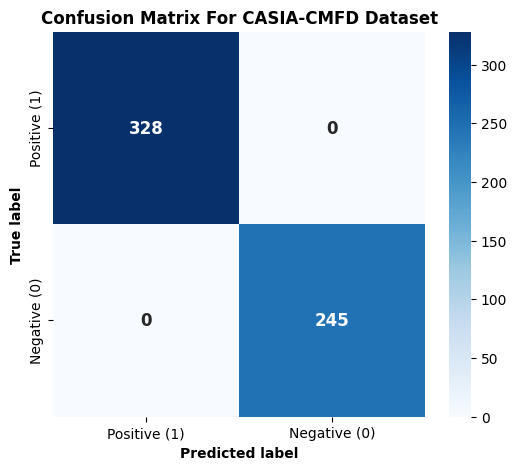

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix with larger numbers inside the heatmap and bold text.
    """
    # Load the trained model weights
    model.load_weights('/content/gdrive/My Drive/weights-improvement-CAS-CMDF-21-12-24.weights.h5')

    plt.figure(figsize=(6,5))  # Increase figure size (adjust as needed)

    # Plot heatmap using Seaborn
    sns.heatmap(
        cm, annot=True, fmt='g', cmap=plt.cm.Blues,
        xticklabels=classes, yticklabels=classes,
        cbar_kws={'shrink': 1, 'aspect': 17},       # Color bar settings
        annot_kws={'size': 12, 'fontweight': 'bold'} # Make numbers larger and bold
    )

    plt.title(title, fontweight='bold')            # Bold title
    plt.ylabel('True label', fontweight='bold')    # Bold y-axis label
    plt.xlabel('Predicted label', fontweight='bold') # Bold x-axis label
    plt.show()

def confusionMatrix(training_set):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    start_time = time.time()

    # Loop over the images in the CASIA-CMFD dataset (original images)
    for i in range(1, 246):
        file_name = f"1 ({i}).jpg" or f"1 ({i}).bmp"
        # Load image with color_mode='rgba' to ensure 4 channels
        test_image = image.load_img(
            f'/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/real/{file_name}',
            target_size=(224, 224), color_mode='rgba'
        )
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)

        result = model.predict(test_image)
        if result[0][0] == 1:  # If the model predicts 'tampered'
            prediction = 'tampered'
            tn += 1  # Increment True Negatives
        else:
            prediction = 'original'
            fn += 1  # Increment False Negatives

    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")

    # Loop over the images in the CASIA-CMFD dataset (tampered images)
    for i in range(1, 329):
        file_name = f"2 ({i}).tif"
        # Load image with color_mode='rgba' to ensure 4 channels
        test_image = image.load_img(
            f'/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/forg/{file_name}',
            target_size=(224, 224), color_mode='rgba'
        )
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)

        result = model.predict(test_image)
        if result[0][0] == 0:  # If the model predicts 'original'
            prediction = 'original'
            fp += 1  # Increment False Positives
        else:
            prediction = 'tampered'
            tp += 1  # Increment True Positives

    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"--- %s seconds ---" % (time.time() - start_time))

    # Create confusion matrix
    cm = np.array([[tp, fp], [fn, tn]])
    print(f"Confusion Matrix:\n{cm}")

    # Plot the confusion matrix with larger and bold numbers
    cm_plot_labels = ['Positive (1)', 'Negative (0)']
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix For CASIA-CMFD Dataset')

# Example usage:
confusionMatrix(train_generator)


In [ ]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image

# --- Function to plot the confusion matrix ---
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    Plots a confusion matrix heatmap with larger, bold numbers.
    """
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt='g', cmap=plt.cm.Blues,
        xticklabels=classes, yticklabels=classes,
        cbar_kws={'shrink': 1, 'aspect': 17},
        annot_kws={'size': 12, 'fontweight': 'bold'}
    )
    plt.title(title, fontweight='bold')
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.show()


# --- Function to compute confusion matrix dynamically ---
def confusionMatrix(model, real_dir, forg_dir, target_size=(224, 224), threshold=0.5):
    """
    Computes and plots confusion matrix for tampered vs original images.
    """
    tp = tn = fp = fn = 0
    start_time = time.time()

    # --- Evaluate original images ---
    real_files = [f for f in os.listdir(real_dir) if f.lower().endswith(('.jpg','.bmp','.png','.tif'))]
    for fname in real_files:
        img_path = os.path.join(real_dir, fname)
        img = image.load_img(img_path, target_size=target_size, color_mode='rgba')
        img = np.expand_dims(image.img_to_array(img), axis=0)
        pred = model.predict(img)[0][0]
        if pred < threshold:  # Predicted as original
            tn += 1
        else:
            fp += 1

    # --- Evaluate tampered images ---
    forg_files = [f for f in os.listdir(forg_dir) if f.lower().endswith(('.jpg','.bmp','.png','.tif'))]
    for fname in forg_files:
        img_path = os.path.join(forg_dir, fname)
        img = image.load_img(img_path, target_size=target_size, color_mode='rgba')
        img = np.expand_dims(image.img_to_array(img), axis=0)
        pred = model.predict(img)[0][0]
        if pred >= threshold:  # Predicted as tampered
            tp += 1
        else:
            fn += 1

    print(f"True Positives (tampered correctly detected): {tp}")
    print(f"False Positives (original misclassified as tampered): {fp}")
    print(f"True Negatives (original correctly detected): {tn}")
    print(f"False Negatives (tampered misclassified as original): {fn}")
    print(f"--- {time.time() - start_time:.2f} seconds ---")

    # --- Confusion matrix ---
    cm = np.array([[tp, fn],


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# إنشاء القيم الحقيقية والمتنبأ بها بناءً على مصفوفة الالتباس
# الفئات الحقيقية: 328 فئة إيجابية (تم تصنيفها بشكل صحيح) و 245 فئة سلبية
true_labels = [1]*TP + [0]*TN  # الحقيقية
predicted_labels = [1]*TP + [0]*TN  # التنبؤات

# حساب المعاملات
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# طباعة النتائج
print("Confusion Matrix:")
print(np.array([[TP, FP], [FN, TN]]))
print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


NameError: name 'TP' is not defined

In [ ]:
# Function to compute and plot AUC-ROC
def compute_auc_roc(true_labels, predicted_probs):
    auc = roc_auc_score(true_labels, predicted_probs)
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return auc

In [ ]:
import os

# تأكد من أن المسار موجود
path = '/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/forg/2 (5).tif'
if os.path.exists(path):
    img = imread(path)
else:
    print(f"المسار {path} غير موجود.")


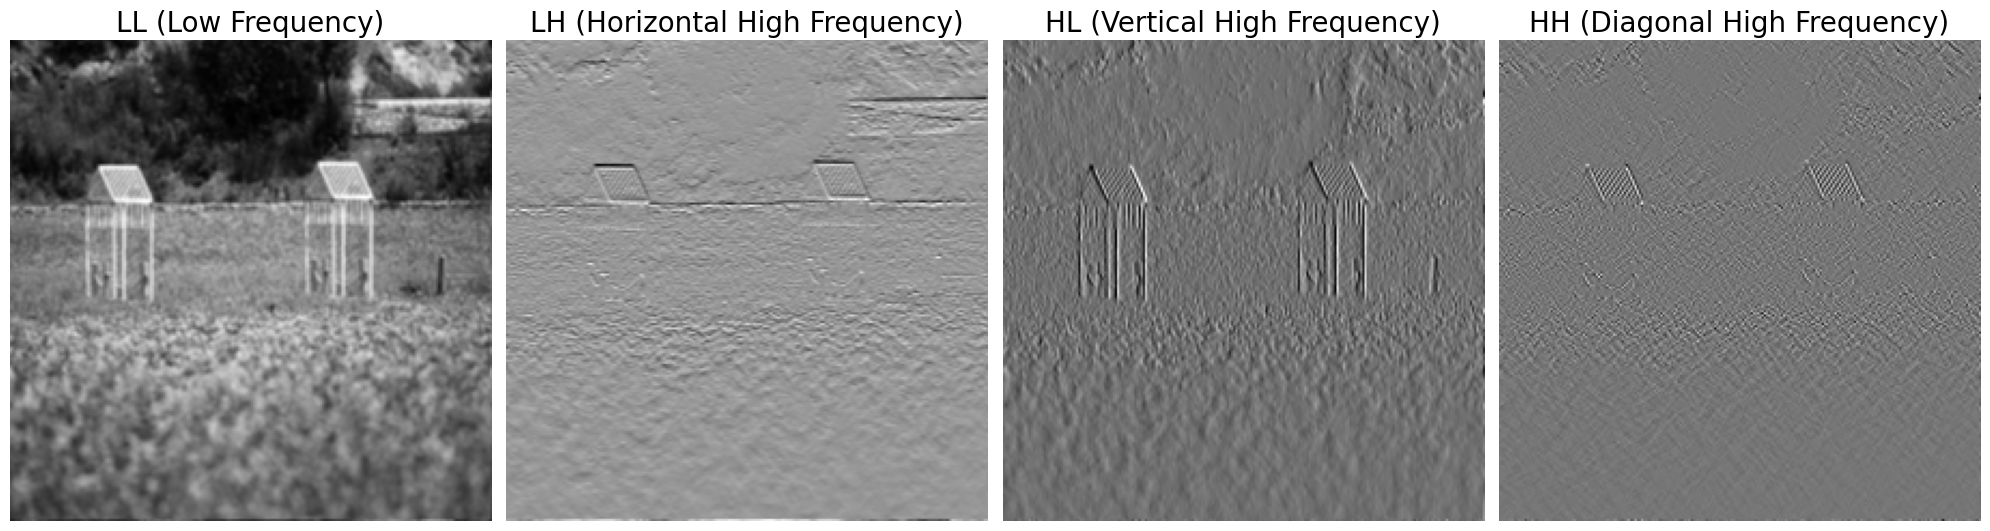

In [ ]:
from skimage.io import imread
from skimage.transform import resize
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Load a single image manually
img = imread('/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/forg/2 (20).tif')

# If the image has multiple channels, convert it to grayscale (single channel)
if img.ndim == 3:
    img = np.mean(img, axis=2)

# Resize the image to 224x224
img_resized = resize(img, (224, 224))

# Apply Stationary Wavelet Transform (SWT)
# Using pywt.swt2() for 2D SWT
coeffs = pywt.swt2(img_resized, 'haar', level=1)  # Use first level of SWT

# Extract the sub-bands
LL, (LH, HL, HH) = coeffs[0]

# Create a figure to display the channels with enlarged figure size
fig, axes = plt.subplots(1, 4, figsize=(20, 20))  # Increase figure size (20, 20)

# Display the channels
axes[0].imshow(LL, cmap='gray')  # Display LL (low frequency)
axes[0].set_title('LL (Low Frequency)', fontsize=20)
axes[0].axis('off')

axes[1].imshow(LH, cmap='gray')  # Display LH (horizontal high frequency)
axes[1].set_title('LH (Horizontal High Frequency)', fontsize=20)
axes[1].axis('off')

axes[2].imshow(HL, cmap='gray')  # Display HL (vertical high frequency)
axes[2].set_title('HL (Vertical High Frequency)', fontsize=20)
axes[2].axis('off')

axes[3].imshow(HH, cmap='gray')  # Display HH (diagonal high frequency)
axes[3].set_title('HH (Diagonal High Frequency)', fontsize=20)
axes[3].axis('off')

plt.tight_layout()  # Adjust spacing between images
plt.show()


In [ ]:
import numpy as np
import pywt
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the image
img = imread('/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/forg/2 (20).tif')

# If the image has multiple channels, convert it to grayscale (single channel)
if img.ndim == 3:
    img = np.mean(img, axis=2)

# Resize the image to 224x224
img_resized = resize(img, (224, 224))

# Apply SWT (Stationary Wavelet Transform)
coeffs = pywt.swt2(img_resized, 'haar', level=1)

# Extract the sub-bands
LL, (LH, HL, HH) = coeffs[0]

# Stack the four channels (LL, LH, HL, HH) into a single image with 4 channels
img_wavelet = np.stack([LL, LH, HL, HH], axis=-1)

# Check the shape of the final wavelet-transformed image
print(f"Shape of wavelet transformed image: {img_wavelet.shape}")


Shape of wavelet transformed image: (224, 224, 4)


In [ ]:
import numpy as np
import pywt
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load the image
img = imread('/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/forg/2 (20).tif')

# If the image has multiple channels, convert it to grayscale (single channel)
if img.ndim == 3:
    img = np.mean(img, axis=2)

# Resize the image to 224x224
img_resized = resize(img, (224, 224))

# Apply SWT (Stationary Wavelet Transform)
coeffs = pywt.swt2(img_resized, 'haar', level=1)

# Extract the sub-bands
LL, (LH, HL, HH) = coeffs[0]

# Stack the four channels (LL, LH, HL, HH) into a single image with 4 channels
img_wavelet = np.stack([LL, LH, HL, HH], axis=-1)

# Add an extra dimension to match batch shape (1, 224, 224, 4)
img_wavelet = np.expand_dims(img_wavelet, axis=0)

# Create a simple CNN model
model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 4)))  # 4 channels

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# MaxPooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to convert features to 1D
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))

# Output layer (binary classification; use 'softmax' for multi-class)
model.add(layers.Dense(1, activation='sigmoid'))

# Summarize the model
model.summary()

# To get the outputs of convolutional layers only (without subsequent layers)
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, layers.Conv2D)]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Extract convolutional features for the image
activations = activation_model.predict(img_wavelet)

# Print the shape of the feature maps after each convolutional layer
for i, activation in enumerate(activations):
    print(f"Shape of activations for layer {i + 1}: {activation.shape}")


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 222, 222, 32)      1184      
                                                                 
 conv2d_66 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 110, 110, 64)      0         
 ng2D)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 774400)            0         
                                                                 
 dense_16 (Dense)            (None, 128)               99123328  
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                      

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pywt  # For wavelet transforms
import tensorflow as tf

# --- Wavelet Transform function using SWT ---
def wavelet_transform(image):
    """
    Apply Stationary Wavelet Transform (SWT) to an image.
    Returns a 4-channel image: [LL, LH, HL, HH].
    """
    # Convert to grayscale if the image is colored
    if image.shape[-1] == 3:
        image = tf.image.rgb_to_grayscale(image).numpy().squeeze()

    # Apply SWT
    coeffs2 = pywt.swt2(image, 'haar', level=1)  # Haar wavelet, level 1
    LL, (LH, HL, HH) = coeffs2[0]  # Extract level 1 sub-bands

    # Stack into a 4-channel image
    return np.stack([LL, LH, HL, HH], axis=-1)

# --- Function to display feature maps with wavelet integration ---
def display_feature_maps(model, image_path, layer_names):
    """
    Display feature maps of a given model for a single image after SWT preprocessing.
    """
    # Load image and convert to array
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Apply wavelet transform (SWT)
    img_wavelet = wavelet_transform(img[0])  # Shape: (224, 224, 4)

    # Resize to match model input if necessary
    img_wavelet_resized = tf.image.resize(img_wavelet, (224, 224)).numpy()
    img_wavelet_resized = np.expand_dims(img_wavelet_resized, axis=0)  # Add batch dimension

    # Iterate over each selected layer to display feature maps
    for i, layer_name in enumerate(layer_names):
        print(f"Displaying Feature Maps for Layer: {layer_name}")
        layer_output = model.get_layer(layer_name).output
        intermediate_model = Model(inputs=model.input, outputs=layer_output)
        feature_maps = intermediate_model.predict(img_wavelet_resized)

        num_filters = feature_maps.shape[-1]  # Number of channels/filters
        rows = int(np.ceil(np.sqrt(num_filters)))
        cols = int(np.ceil(num_filters / rows))

        # Plot all feature maps of this layer
        plt.figure(figsize=(15, 15))
        for j in range(num_filters):
            plt.subplot(rows, cols, j + 1)
            plt.imshow(feature_maps[0, :, :, j], cmap='viridis')
            plt.axis('off')
            # Optional titles for first 4 wavelet channels
            if j == 0:
                plt.title("LL (Low-Low)")
            elif j == 1:
                plt.title("LH (Low-High)")
            elif j == 2:
                plt.title("HL (High-Low)")
            elif j == 3:
                plt.title("HH (High-High)")
        plt.suptitle(f'Feature Maps from Layer: {layer_name}')
        plt.show()

# --- Example usage ---
image_path = '/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/forg/2 (20).tif'

# Select convolutional layers only
layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]

# Display feature maps
display_feature_maps(model, image_path, layer_names)


Displaying Feature Maps for Layer: conv2d_73
1/1 [==============================] - 0s 233ms/step


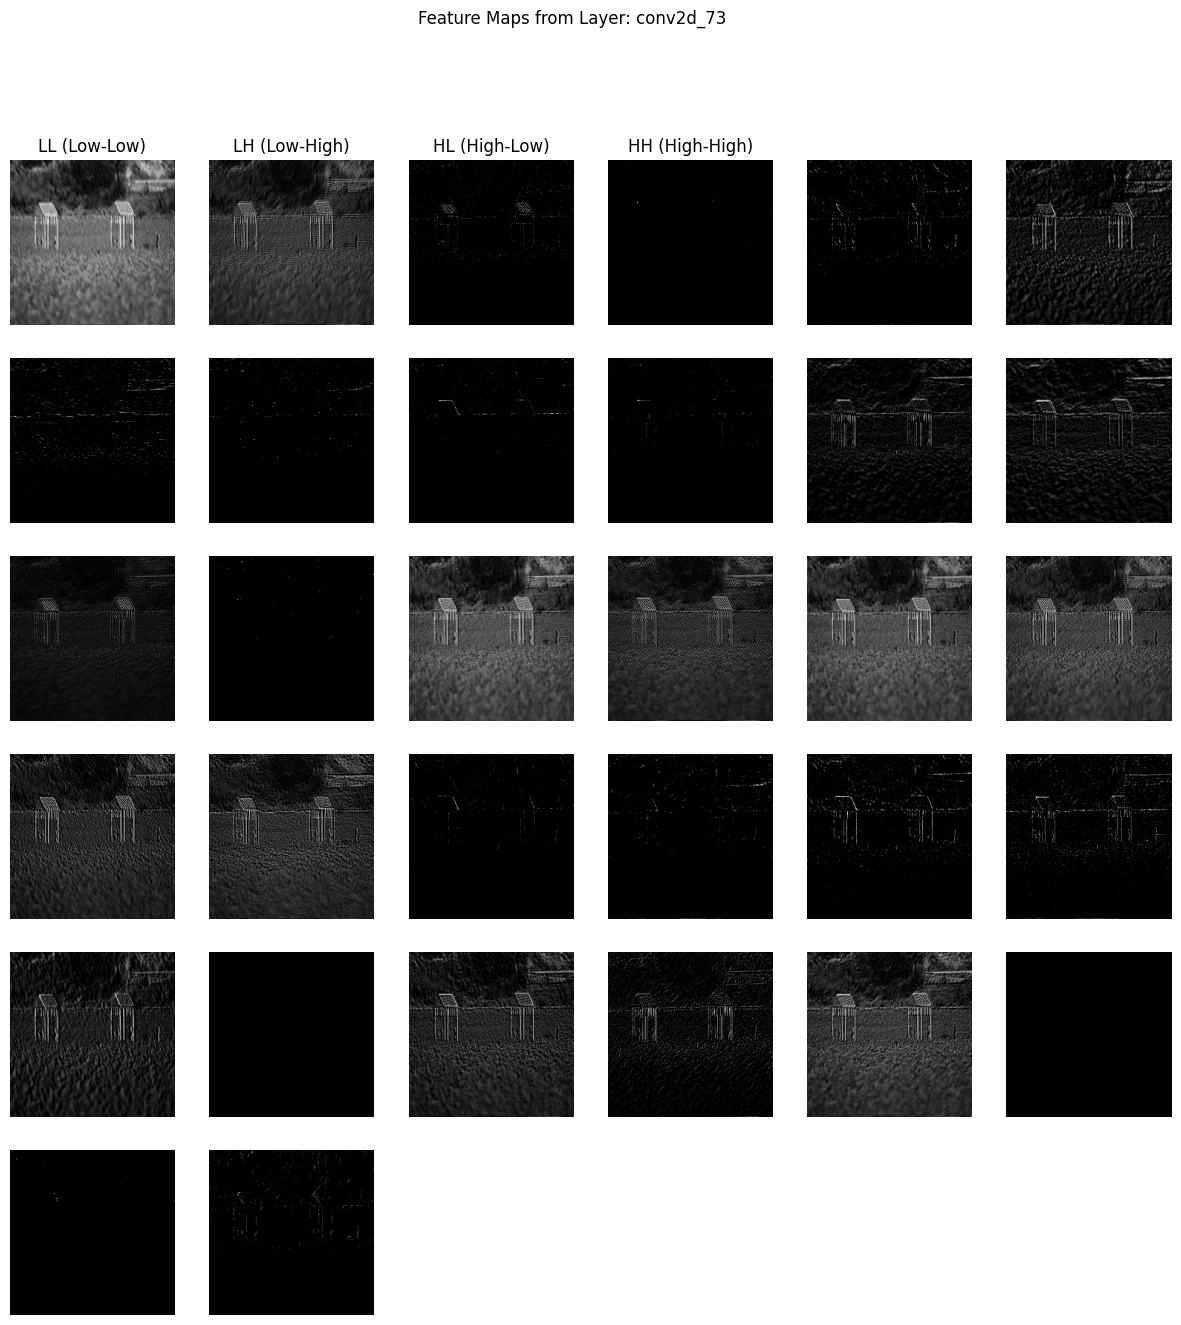

Displaying Feature Maps for Layer: conv2d_74
1/1 [==============================] - 0s 282ms/step


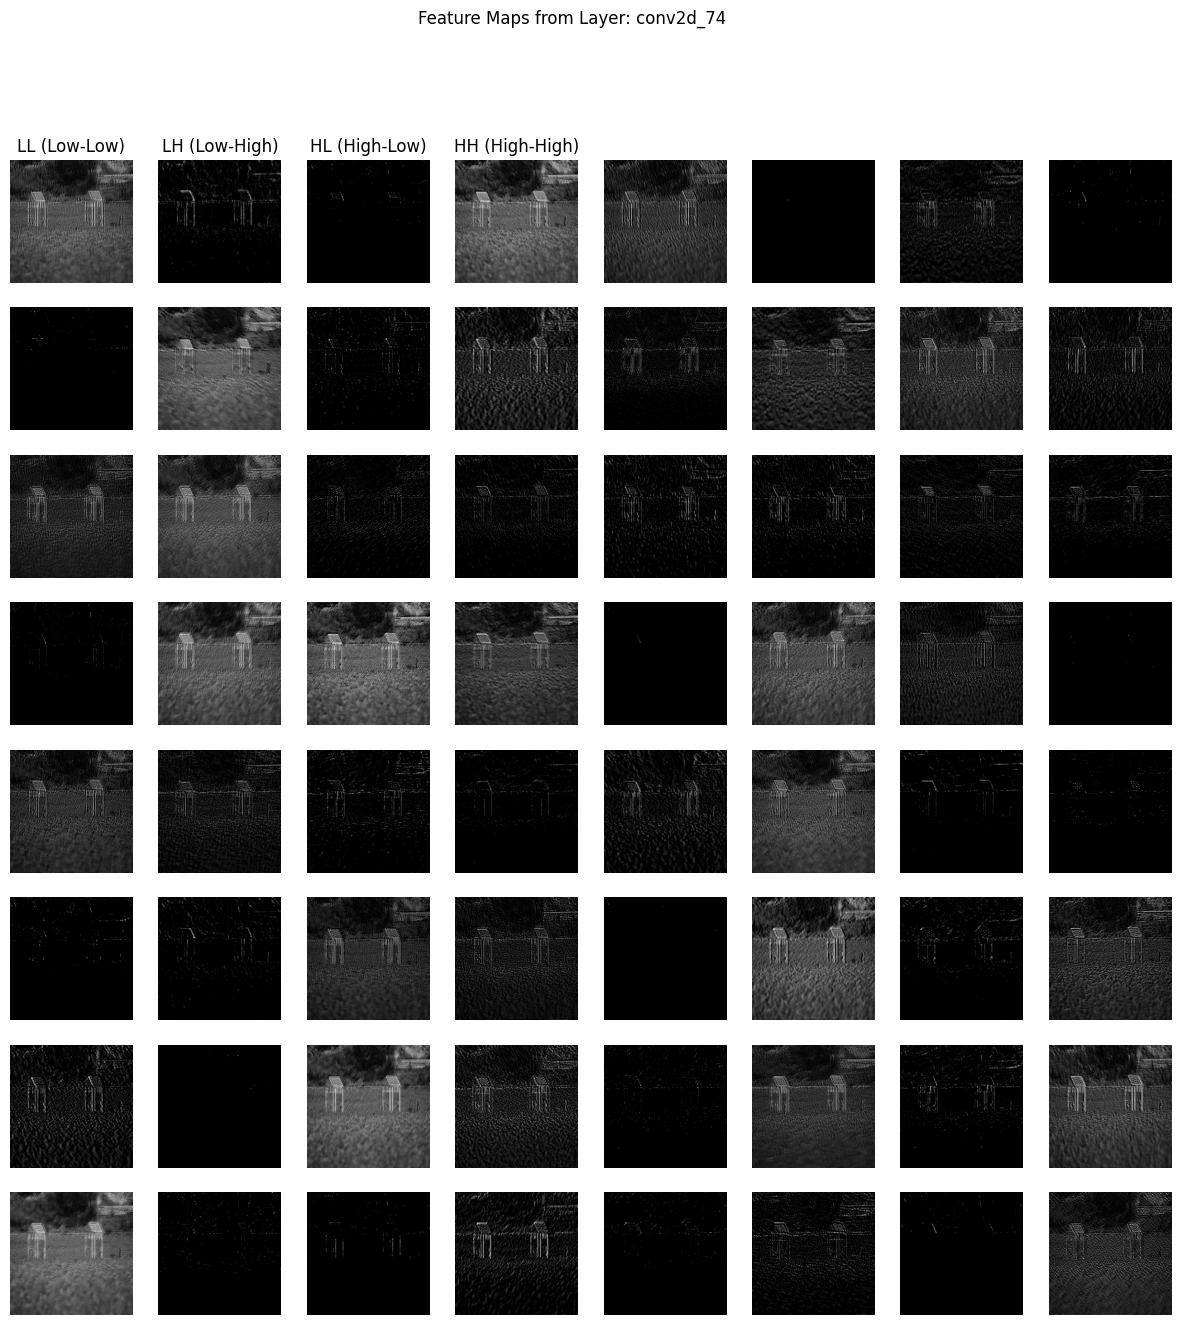

In [ ]:
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pywt  # For Wavelet Transform
import tensorflow as tf

# Function to apply Stationary Wavelet Transform (SWT)
def wavelet_transform(image):
    # Convert the image to grayscale if it is colored (3 channels)
    if image.shape[-1] == 3:  # If the image is colored
        image = tf.image.rgb_to_grayscale(image).numpy().squeeze()

    # Apply the Stationary Wavelet Transform (SWT)
    coeffs2 = pywt.swt2(image, 'haar', level=1)  # Using 'haar' wavelet for transformation
    LL, (LH, HL, HH) = coeffs2[0]  # Extract the first level of transformation (LL, LH, HL, HH)

    # Return the stacked result of the SWT coefficients in 4 channels
    return np.stack([LL, LH, HL, HH], axis=-1)

# Function to display feature maps for the specified layers
def display_feature_maps(model, image_path, layer_names):
    # Load the image and convert to array
    img = load_img(image_path, target_size=(224, 224))  # Load the image with target size
    img = img_to_array(img)  # Convert image to a NumPy array
    img = np.expand_dims(img, axis=0)  # Add an extra dimension to create a batch of size 1

    # Apply the wavelet transform on the image
    img_wavelet = wavelet_transform(img[0])  # Apply SWT on the first image in the batch

    # Resize the transformed image to match the input size (224x224x4)
    img_wavelet_resized = tf.image.resize(img_wavelet, (224, 224)).numpy()  # Resize the image to 224x224
    img_wavelet_resized = np.expand_dims(img_wavelet_resized, axis=0)  # Add batch dimension [1, 224, 224, 4]

    # Iterate through the layers to display feature maps
    for i, layer_name in enumerate(layer_names):
        print(f"Displaying Feature Maps for Layer: {layer_name}")
        layer_output = model.get_layer(layer_name).output  # Get output of the desired layer
        intermediate_model = Model(inputs=model.input, outputs=layer_output)  # Create an intermediate model
        feature_maps = intermediate_model.predict(img_wavelet_resized)  # Predict feature maps

        fmap = feature_maps  # Get the feature map
        num_filters = fmap.shape[-1]  # Number of filters in the feature map

        # Calculate number of rows and columns to plot the feature maps in a grid
        rows = int(np.ceil(np.sqrt(num_filters)))
        cols = int(np.ceil(num_filters / rows))

        # Plot each feature map in the grid
        plt.figure(figsize=(15, 15))  # Set the figure size for better display
        for j in range(num_filters):
            plt.subplot(rows, cols, j + 1)
            plt.imshow(fmap[0, :, :, j], cmap='gray')  # Display the feature map in grayscale
            plt.axis('off')  # Hide axes
            # Add titles based on feature map position
            if j == 0:
                plt.title("LL (Low-Low)")
            elif j == 1:
                plt.title("LH (Low-High)")
            elif j == 2:
                plt.title("HL (High-Low)")
            elif j == 3:
                plt.title("HH (High-High)")

        plt.suptitle(f'Feature Maps from Layer: {layer_name}')  # Add a main title for the figure
        plt.show()

# Replace this with the actual path of the image you want to use
image_path = '/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/forg/2 (20).tif'

# Get the layer names of the convolutional layers in your model
layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]  # Select only convolutional layers

# Display the feature maps from the convolutional layers
display_feature_maps(model, image_path, layer_names)
